In [1]:
# class RobotabilityGraph that inherits from Graph class 
import os
import sys 
sys.path.append("/share/ju/urban-fingerprinting")

import osmnx as ox 
import geopandas as gpd 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
# enable latex plotting 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from glob import glob 
from tqdm import tqdm 

from shapely import wkt, LineString 

import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show 


from src.utils.logger import setup_logger 

logger = setup_logger('robotability-score')
logger.setLevel("INFO")
logger.info("Modules initialized.")

WGS='EPSG:4326'
PROJ='EPSG:2263'

REGEN_SEGMENTIZATION=True
REGEN_TOPOLOGY=True



2024-12-10 10:28:28 - robotability-score - INFO - Modules initialized.


In [2]:
deployments = { 
    'Elmhurst, Queens': {
        'coords': (40.738536, -73.887267),
        'type': 'high',
    },
    'Sutton Place, Manhattan': {
        'coords': (40.758890, -73.958457),
        'type': 'high',
    },
    'Herald Square, Manhattan': {
        'coords': (40.748422, -73.988275),
        'type': 'low',
    },
    'Jackson Heights, Queens': {
        'coords': (40.747379, -73.889690),
        'type': 'low'
    }
}

deployments = pd.DataFrame(deployments).T
deployments = gpd.GeoDataFrame(deployments, geometry=gpd.points_from_xy(deployments['coords'].apply(lambda x: x[1]), deployments['coords'].apply(lambda x: x[0]))).set_crs(WGS).to_crs(PROJ)

In [3]:
ntas_nyc = gpd.read_file("../data/2020 Neighborhood Tabulation Areas (NTAs)/geo_export_ec7bcc3d-bf45-4337-8767-b0dd7fe592a8.shp", crs=WGS).to_crs(PROJ)

In [4]:
cbs_nyc = gpd.read_file("../data/nycb2020_24c/nycb2020.shp")
all_cbs_nyc = cbs_nyc.copy()

In [5]:
score_nyc = pd.read_csv("../data/processed/score_nyc_trashbot.csv", engine='pyarrow')

<Axes: >

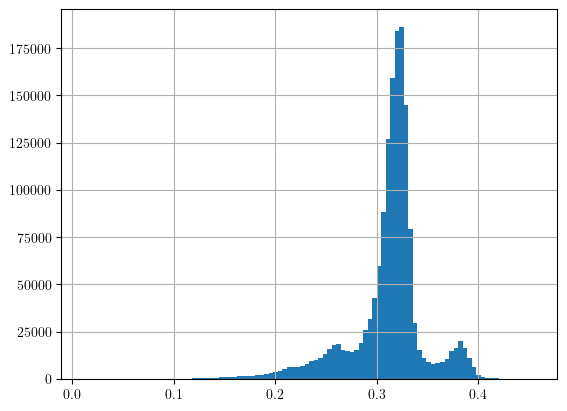

In [6]:
score_nyc['score'].hist(bins=100)

In [7]:
# compute score relative to average in score_rta column 
score_nyc['score_rta'] = score_nyc['score'] / score_nyc['score'].mean()
score_nyc['score_rta'].describe() 

count    1.564796e+06
mean     1.000000e+00
std      1.200020e-01
min      3.651389e-02
25%      9.743676e-01
50%      1.020266e+00
75%      1.050546e+00
max      1.461836e+00
Name: score_rta, dtype: float64

In [8]:
# how many times larger is the largest score than the minimum score 
score_nyc['score'].max() / score_nyc['score'].min()

40.03507075727471

In [9]:
score_nyc['score'].describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

# clip between 0.01 and 0.99 percentiles 
score_nyc = score_nyc[(score_nyc['score'] > score_nyc['score'].quantile(0.001)) & (score_nyc['score'] < score_nyc['score'].quantile(0.999))]

In [10]:
score_nyc['score_percentile'] = score_nyc['score'].rank(pct=True) * 100
score_nyc['score_percentile'].describe()

count    1.561666e+06
mean     5.000003e+01
std      2.886752e+01
min      6.403418e-05
25%      2.500005e+01
50%      5.000003e+01
75%      7.500002e+01
max      1.000000e+02
Name: score_percentile, dtype: float64

In [11]:
score_nyc = gpd.GeoDataFrame(score_nyc, geometry=wkt.loads(score_nyc['geometry']), crs=PROJ)

In [12]:
score_nyc['score'].describe()

count    1.561666e+06
mean     3.118612e-01
std      3.672046e-02
min      1.242553e-01
25%      3.038211e-01
50%      3.180789e-01
75%      3.274973e-01
max      4.090539e-01
Name: score, dtype: float64

In [13]:
# merge score_nyc with cbs_nyc 
by_cb = score_nyc.sjoin(cbs_nyc, how='left', op='intersects')



/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
score_by_cb = by_cb.groupby('BCTCB2020').agg({'score':'mean', 'score_rta':'mean', 'score_percentile': 'mean'}).reset_index()

In [15]:
score_by_cb['score'].max() / score_by_cb['score'].min()

3.198863613624032

In [16]:
cbs_nyc = cbs_nyc.merge(score_by_cb, on='BCTCB2020', suffixes=('', '_mean'))

In [17]:
by_nta = score_nyc.sjoin(ntas_nyc, how='left', op='intersects')
score_by_nta = by_nta.groupby('ntaname').agg({'score':'mean', 'score_rta':'mean', 'score_percentile': 'mean'}).reset_index()

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
score_by_nta['score'].max() / score_by_nta['score'].min()

1.873684038861204

/tmp/ipykernel_3450644/1504073257.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')
/tmp/ipykernel_3450644/1504073257.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_xticklabels([str(int(tick)) + r'\textsuperscript{th}' for tick in cbar.get_xticks()])


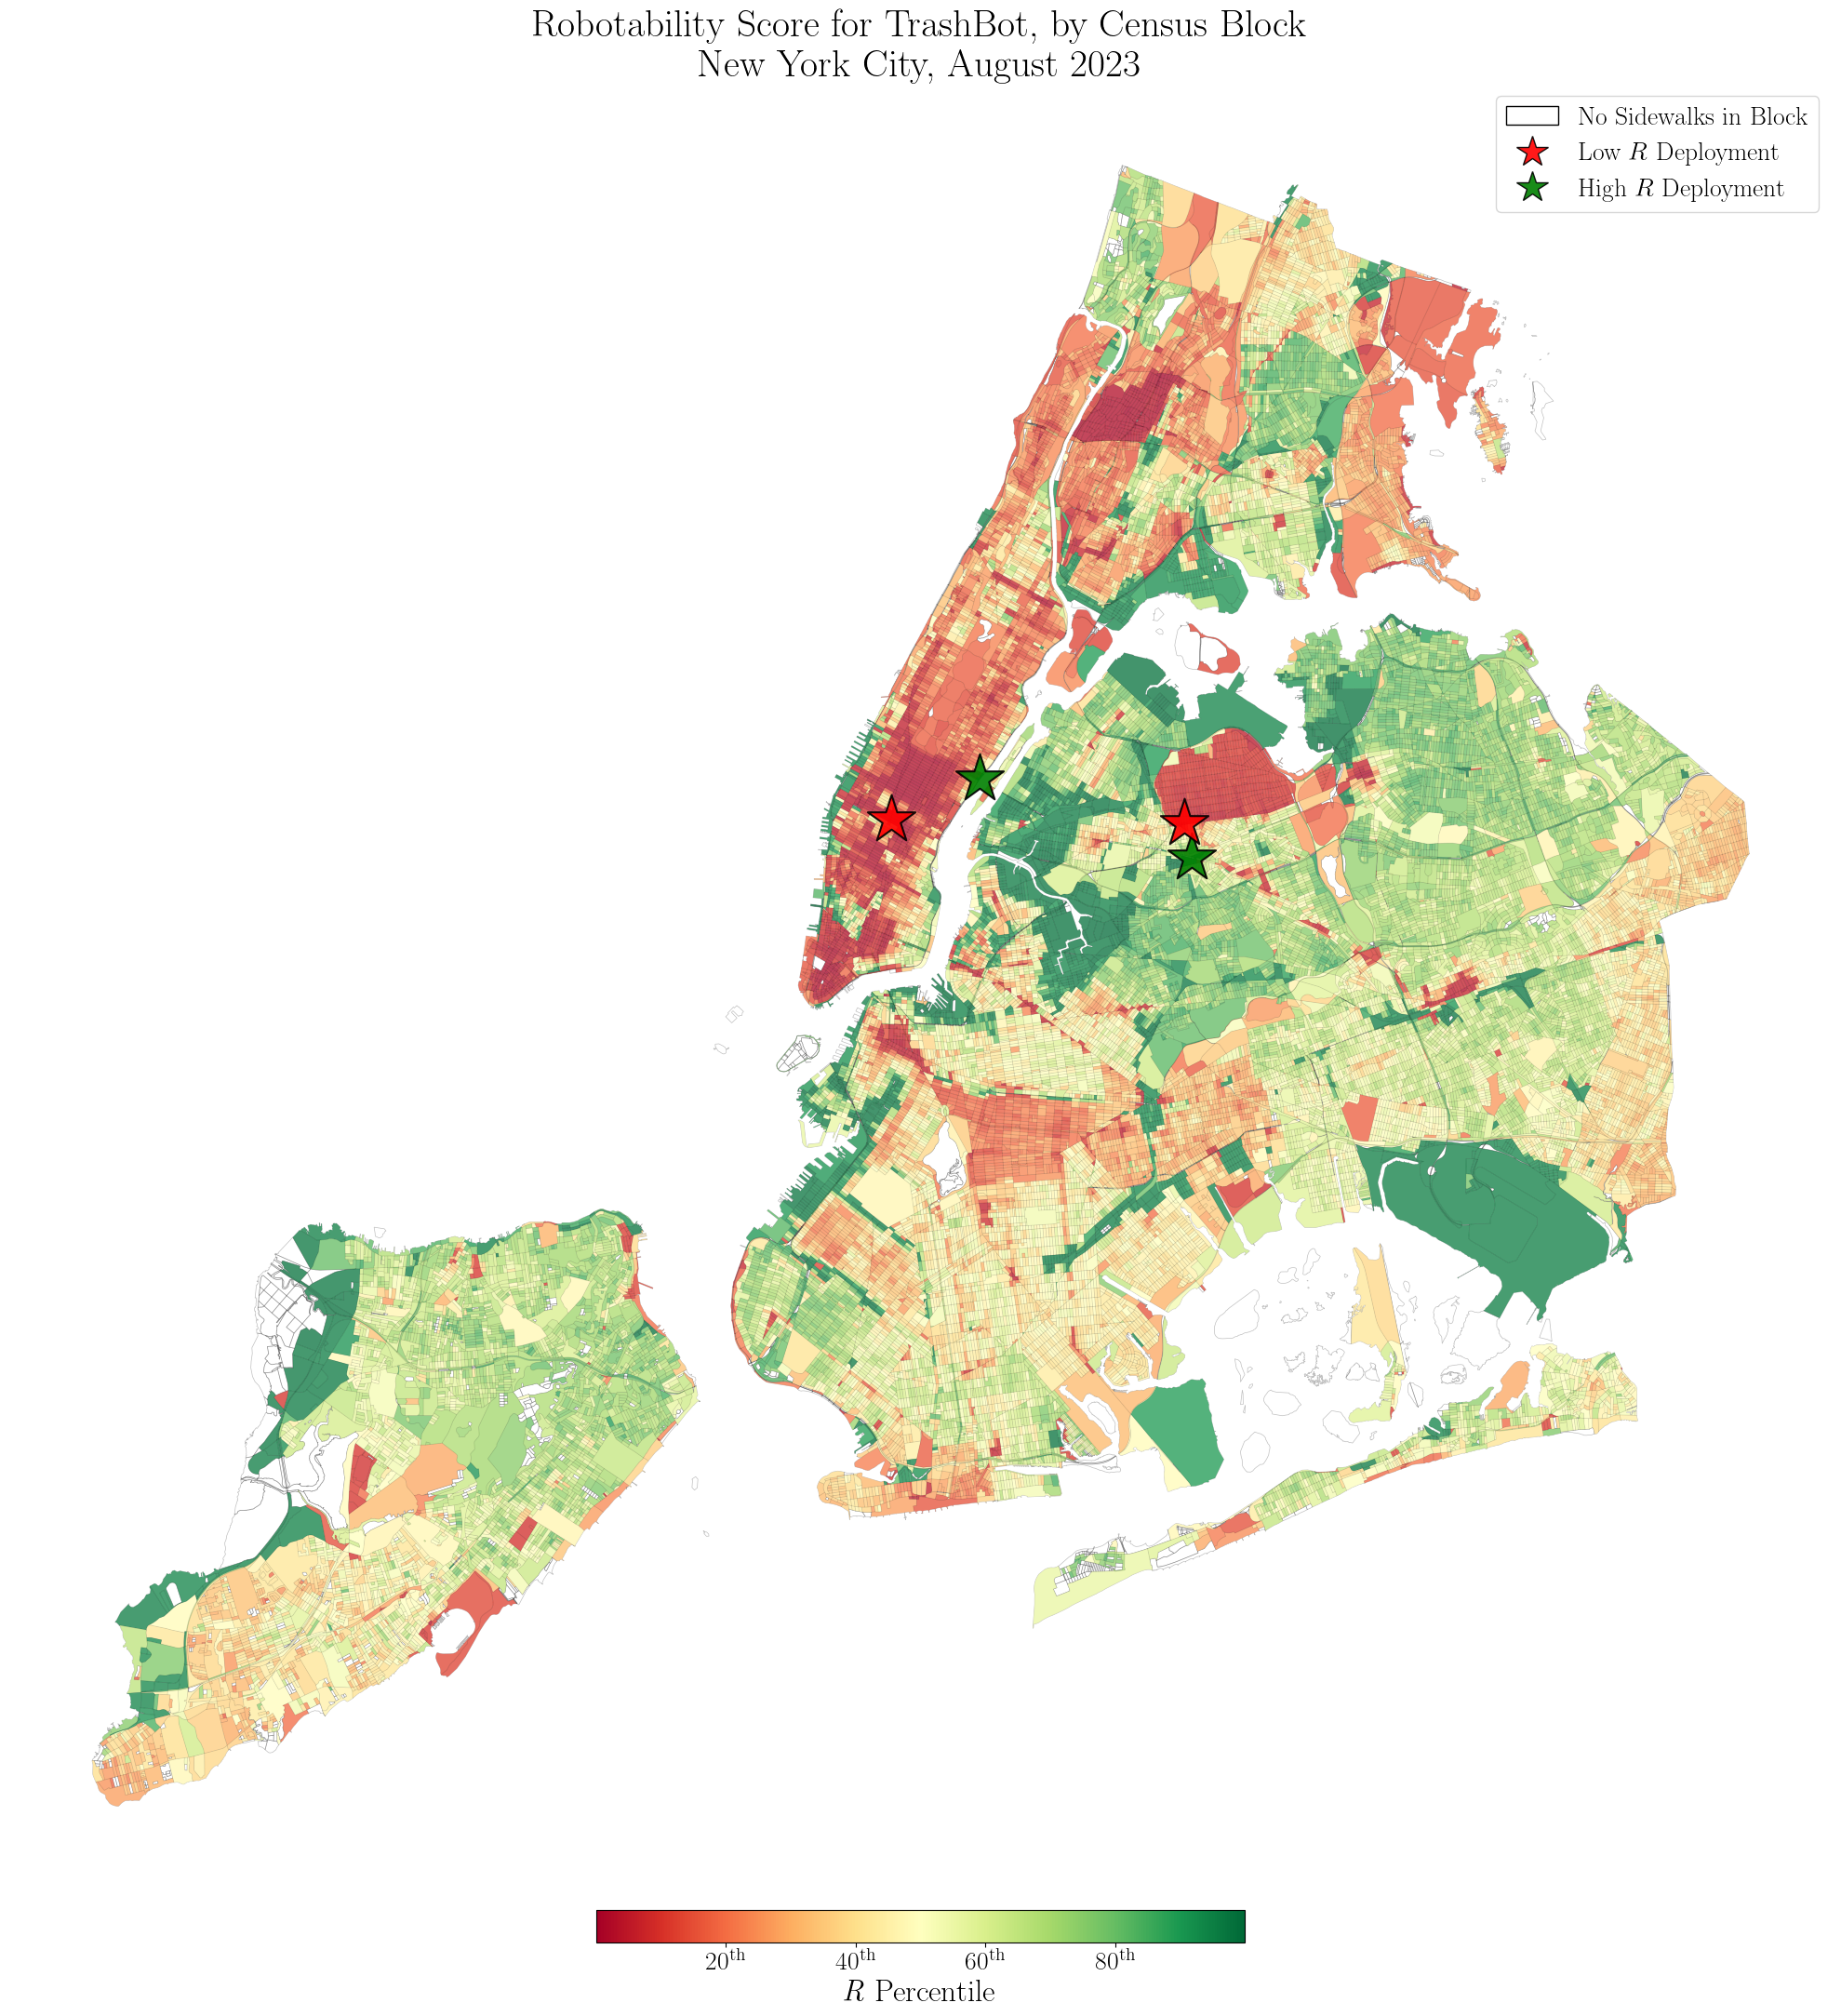

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30))

# get coolwarm colormap and inverse it 
cmap = plt.cm.get_cmap('RdYlGn')
#cmap = cmap.reversed()

all_cbs_nyc.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.25, zorder=0)
cbs_nyc.plot(column='score_percentile', ax=ax, legend=True, cmap=cmap, legend_kwds={'orientation': "horizontal", 'shrink': 0.3, 'pad': 0.01}, zorder=1, alpha=0.75),

# set colorbar font size 
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=20)
# set label font size on colorbar 
cbar.set_xlabel(r"\textit{R} Percentile", fontsize=24)

# add 'th' to the end of the percentile for each tick label 
cbar.set_xticklabels([str(int(tick)) + r'\textsuperscript{th}' for tick in cbar.get_xticks()])

plt.title("Robotability Score for TrashBot, by Census Block" "\n" "New York City, August 2023", fontsize=30)

# add legend for blank census blocks 
from matplotlib.patches import Patch

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# add red and green markers for high and low deployements
for i, row in deployments.iterrows():
    ax.scatter(row['geometry'].x, row['geometry'].y, 
              color='red' if row['type'] == 'low' else 'green', 
              s=1500, marker='*', zorder=2, 
              edgecolor='black', linewidth=1.5, alpha=0.9)

# Create legend elements with matching markers
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='No Sidewalks in Block'),
    Line2D([0], [0], marker='*', color='red', label=r'Low $R$ Deployment',
           markerfacecolor='red', markersize=25, linestyle='none',
           markeredgecolor='black', markeredgewidth=1, alpha=0.9),
    Line2D([0], [0], marker='*', color='green', label=r'High $R$ Deployment',
           markerfacecolor='green', markersize=25, linestyle='none',
           markeredgecolor='black', markeredgewidth=1, alpha=0.9)
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

ax.set_axis_off()

plt.savefig("../chi24_roving_whiteboards/figures/robotability_score_by_cb_trashbot.pdf", dpi=300, bbox_inches='tight')

In [20]:
# top ten census blocks 
top_ten = cbs_nyc.sort_values('score_percentile', ascending=False).head(10)
top_ten['latitude'] = top_ten.centroid.y
top_ten['longitude'] = top_ten.centroid.x
top_ten = top_ten[['BCTCB2020', 'score_percentile', 'latitude', 'longitude']]
top_ten = gpd.GeoDataFrame(top_ten, geometry=gpd.points_from_xy(top_ten.longitude, top_ten.latitude), crs=PROJ)
print(top_ten)

         BCTCB2020  score_percentile       latitude     longitude  \
31908  30021002026         99.985400  194638.578873  9.878143e+05   
20050  40299001002         99.972081  216262.585297  1.011508e+06   
20907  40019021015         99.934877  211294.040112  1.000845e+06   
18053  40919003006         99.934621  222896.608603  1.026032e+06   
25814  30126001001         99.892572  171498.633262  9.786178e+05   
27135  30191001003         99.842556  193295.691502  9.944999e+05   
682    10047002003         99.800405  202859.804667  9.832848e+05   
20046  40141002002         99.778666  218609.182839  1.010896e+06   
7550   40297001000         99.721067  217924.864486  1.011079e+06   
25869  30191001001         99.709925  193376.324752  9.947178e+05   

                             geometry  
31908   POINT (987814.321 194638.579)  
20050  POINT (1011507.600 216262.585)  
20907  POINT (1000844.643 211294.040)  
18053  POINT (1026031.826 222896.609)  
25814   POINT (978617.848 171498.633)  


In [21]:
# bottom ten 
bottom_ten = cbs_nyc.sort_values('score_percentile', ascending=True).head(10)
bottom_ten['latitude'] = bottom_ten.centroid.y
bottom_ten['longitude'] = bottom_ten.centroid.x
bottom_ten = bottom_ten[['BCTCB2020', 'score_percentile', 'latitude', 'longitude']]
bottom_ten = gpd.GeoDataFrame(bottom_ten, geometry=gpd.points_from_xy(bottom_ten.longitude, bottom_ten.latitude), crs=PROJ)
print(bottom_ten)

         BCTCB2020  score_percentile       latitude     longitude  \
5088   20237031002          0.016869  253366.007731  1.012231e+06   
20258  20237021001          0.035859  253300.289210  1.012645e+06   
20260  20237031000          0.054205  253312.849879  1.012591e+06   
5085   20237021000          0.096841  253248.696237  1.012824e+06   
220    10015021002          0.102263  197706.759036  9.815187e+05   
5091   20237031005          0.103079  252935.026383  1.012436e+06   
34905  20237021002          0.106265  252913.582488  1.012487e+06   
5087   20237031001          0.114685  253341.346142  1.012452e+06   
34908  20237021006          0.157044  252540.721668  1.012336e+06   
34907  20237021005          0.159441  252498.605521  1.012418e+06   

                             geometry  
5088   POINT (1012231.415 253366.008)  
20258  POINT (1012645.326 253300.289)  
20260  POINT (1012590.725 253312.850)  
5085   POINT (1012824.426 253248.696)  
220     POINT (981518.741 197706.759)  


In [22]:
top_ten.to_crs(WGS).to_csv("../data/processed/top_ten_cb_trashbot.csv", index=False)
bottom_ten.to_crs(WGS).to_csv("../data/processed/bottom_ten_cb_trashbot.csv", index=False)

/tmp/ipykernel_3450644/1704197035.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')


/tmp/ipykernel_3450644/1704197035.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_xticklabels([str(int(tick)) + r'\textsuperscript{th}' for tick in cbar.get_xticks()])


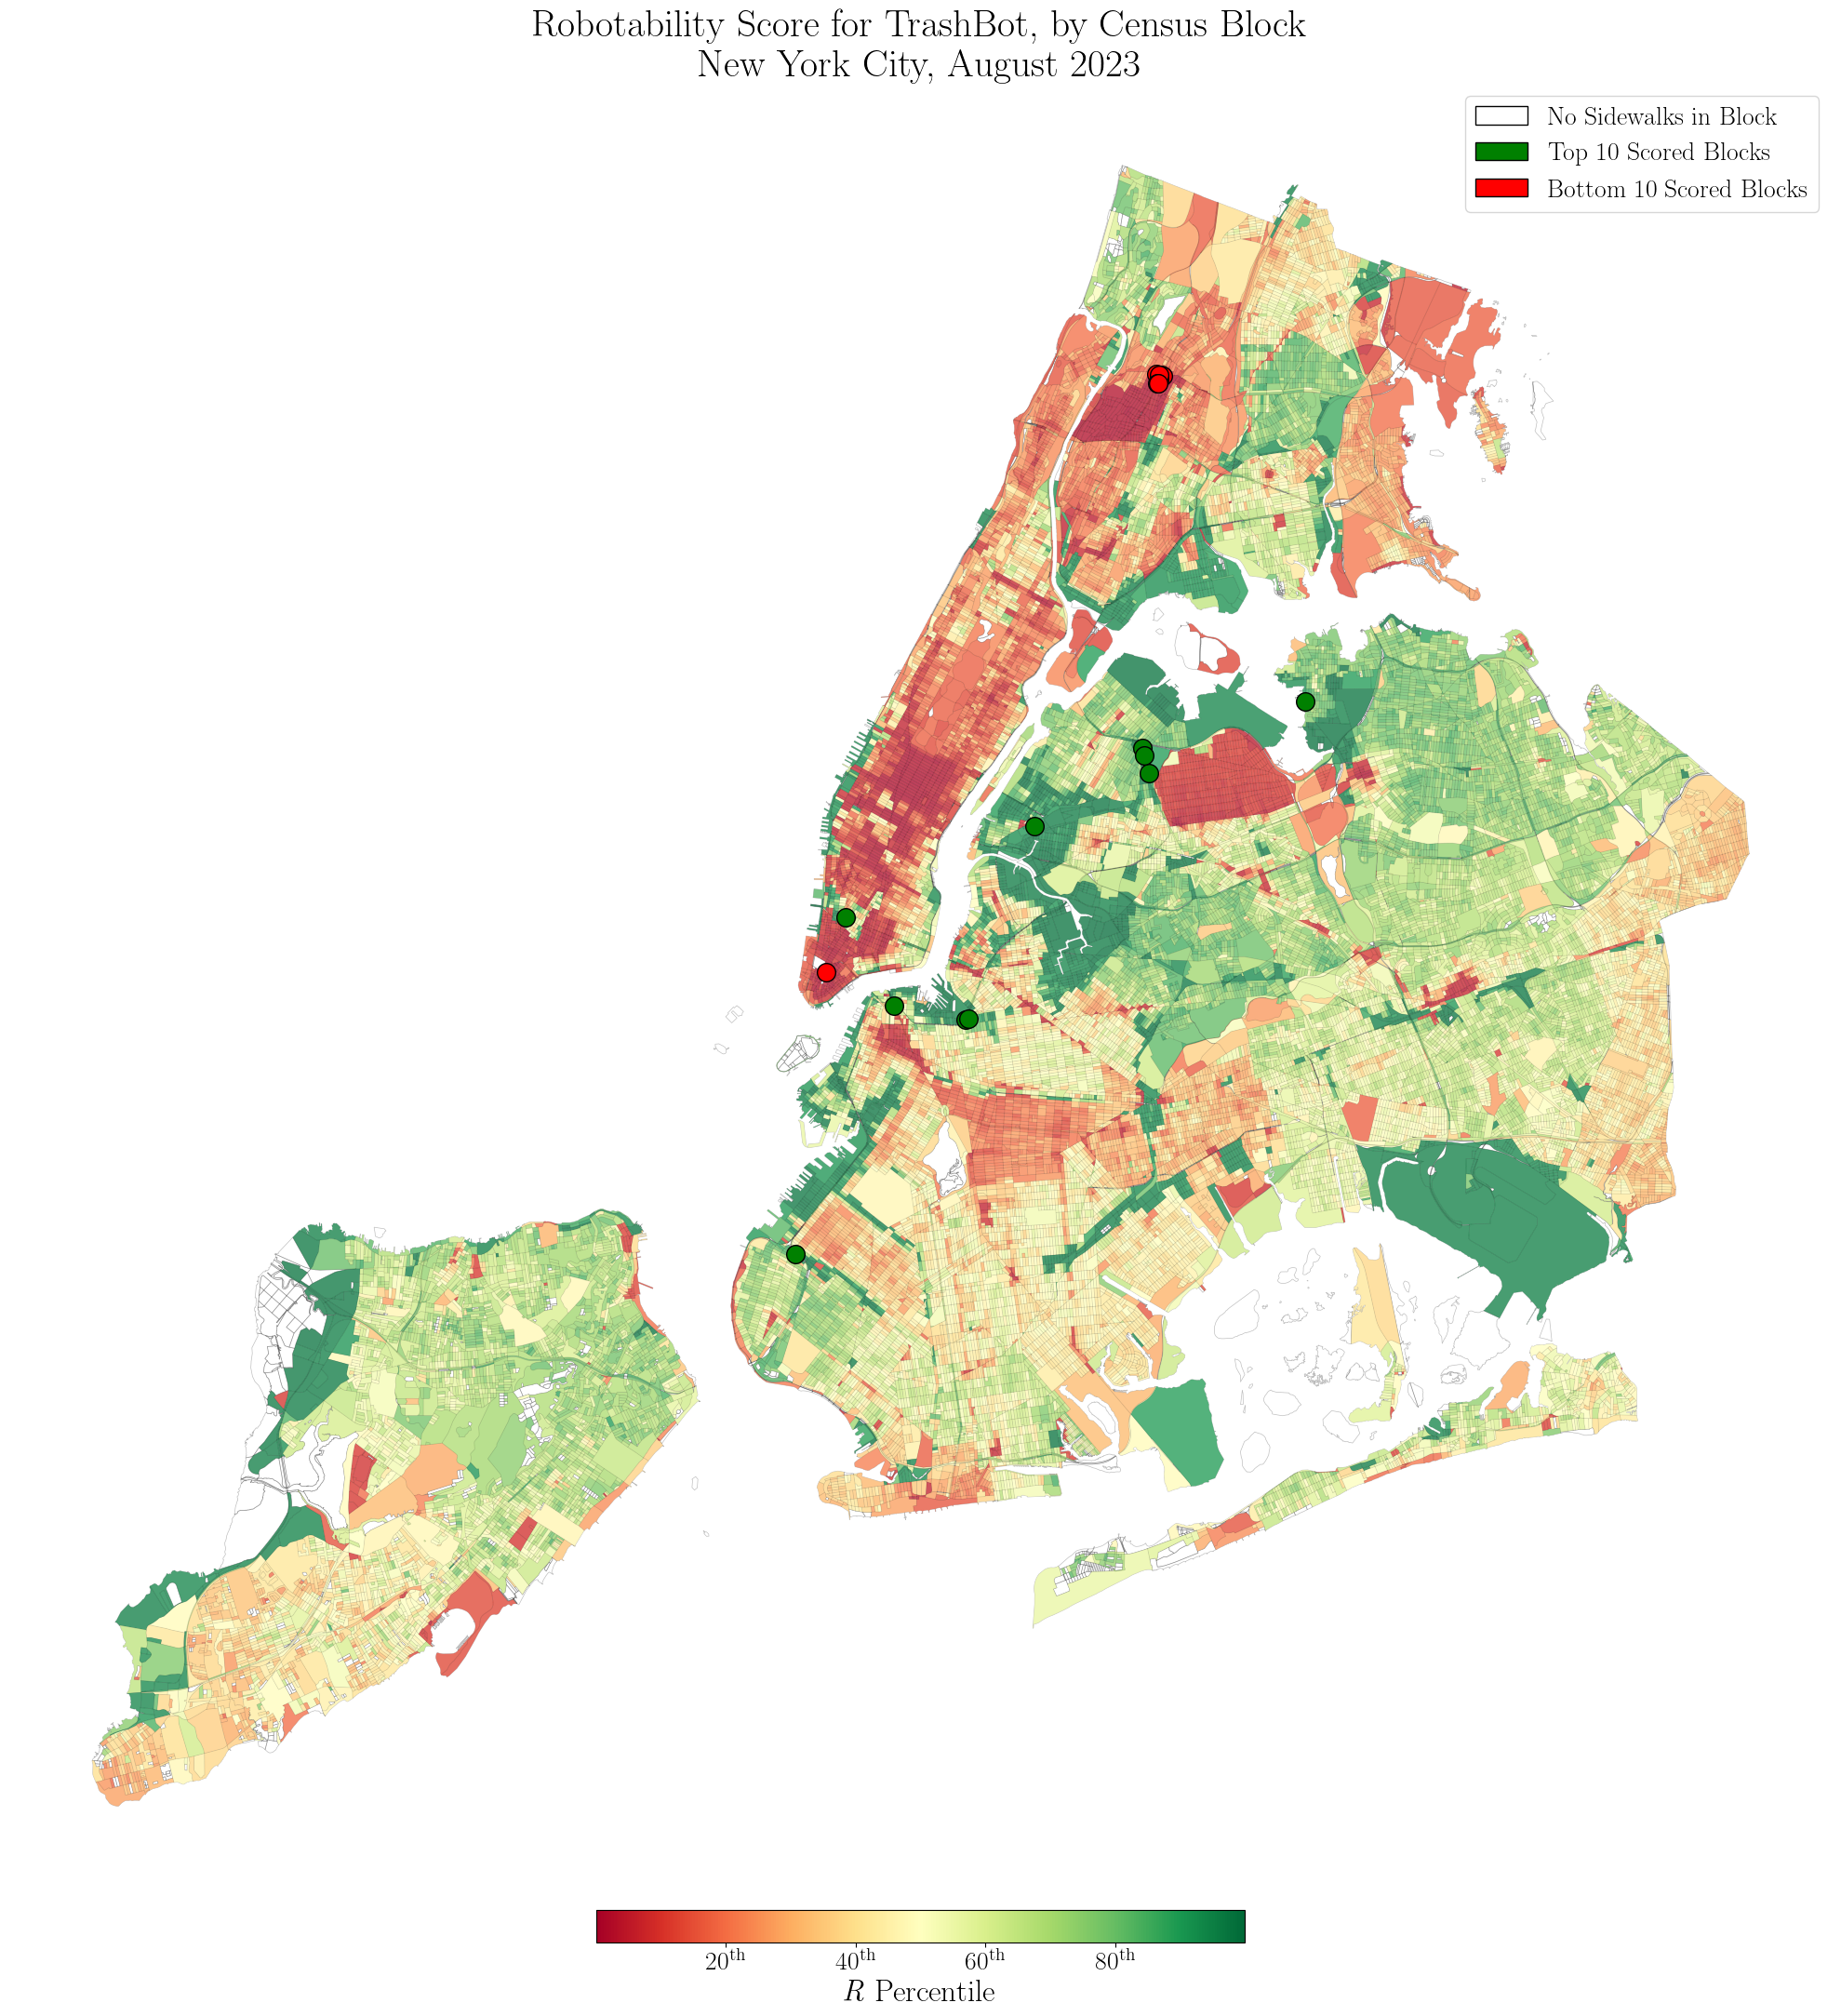

In [23]:
# new map and plot the top 10 and bottom 10 as bigger markers 
fig, ax = plt.subplots(1, 1, figsize=(30, 30))

# get coolwarm colormap and inverse it 
cmap = plt.cm.get_cmap('RdYlGn')
#cmap = cmap.reversed()

all_cbs_nyc.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.25, zorder=0)
cbs_nyc.plot(column='score_percentile', ax=ax, legend=True, cmap=cmap, legend_kwds={'orientation': "horizontal", 'shrink': 0.3, 'pad': 0.01}, zorder=1, alpha=0.75),


top_ten.plot(ax=ax, color='green', markersize=200, zorder=2, edgecolor='black')
bottom_ten.plot(ax=ax, color='red', markersize=200, zorder=2, edgecolor='black')

# set colorbar font size 
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=20)
# set label font size on colorbar 
cbar.set_xlabel(r"\textit{R} Percentile", fontsize=24)

# add 'th' to the end of the percentile for each tick label 
cbar.set_xticklabels([str(int(tick)) + r'\textsuperscript{th}' for tick in cbar.get_xticks()])

plt.title("Robotability Score for TrashBot, by Census Block" "\n" "New York City, August 2023", fontsize=30)

# add legend for blank census blocks 
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor='white', edgecolor='black', label='No Sidewalks in Block'),
                    Patch(facecolor='green', edgecolor='black', label='Top 10 Scored Blocks'),
                    Patch(facecolor='red', edgecolor='black', label='Bottom 10 Scored Blocks')]

ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

ax.set_axis_off()

plt.savefig("../figures/robotability_score_by_cb_trashbot.pdf", dpi=300, bbox_inches='tight')
    